In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv('Data/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'

In [11]:
df.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


In [12]:
df.columns = ['Value']

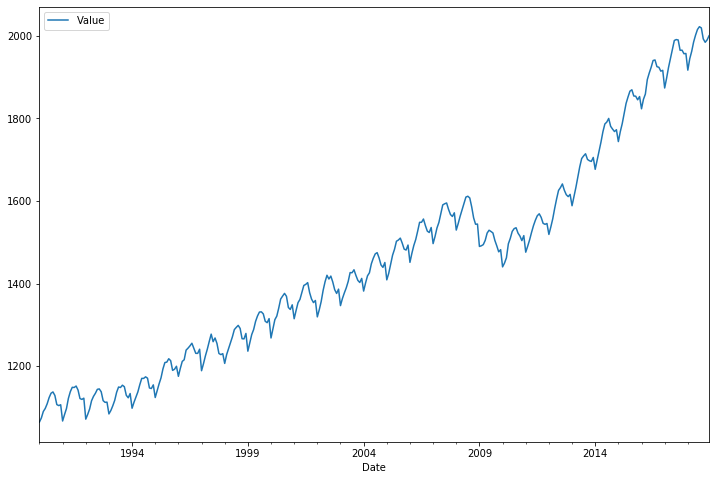

In [13]:
df.plot(figsize=(12,8))

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

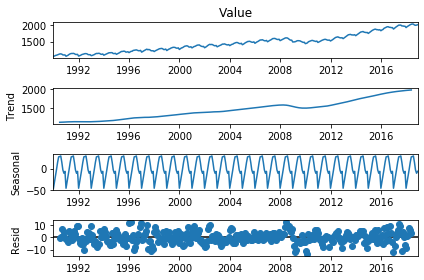

In [15]:
results = seasonal_decompose(df['Value'])
results.plot();

## Train Test Split

In [16]:
len(df)

348

In [17]:
train_len = len(df)-12

In [18]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

## Scale Data

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
n_input = 12 #based on seasionality
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

## Create the Model

TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


## TASK: Fit the model to the generator

In [28]:
model.fit_generator(generator,epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0119
Epoch 2/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0020
Epoch 3/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0016
Epoch 4/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 5/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 6/30
324/324 [==============================] - 3s 8ms/step - loss: 0.0017
Epoch 7/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 8/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 9/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 10/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0015
Epoch 11/30
324/324 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 12/30
324/324 [==========

In [29]:
model.history.history.keys()

dict_keys(['loss'])

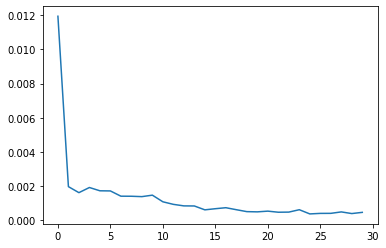

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [31]:
first_eval_batch = scaled_train[-12:]

In [32]:
first_eval_batch

array([[0.87338083],
       [0.89896373],
       [0.92713731],
       [0.95088515],
       [0.97463299],
       [0.99762522],
       [1.        ],
       [0.99892055],
       [0.97193437],
       [0.9722582 ],
       [0.96297496],
       [0.96362263]])

In [33]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

### Forecast: Generate predictions into the same time stamps as the test set

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

In [37]:
test

,Value,Predictions
Date,,
2018-01-01,1916.8,1933.911976
2018-02-01,1944.5,1913.136245
2018-03-01,1962.2,1888.976164
2018-04-01,1984.9,1866.601161
2018-05-01,2001.5,1848.455506
2018-06-01,2015.3,1835.112746
2018-07-01,2022.1,1826.001543
2018-08-01,2019.1,1819.828806
2018-09-01,1992.5,1814.597809


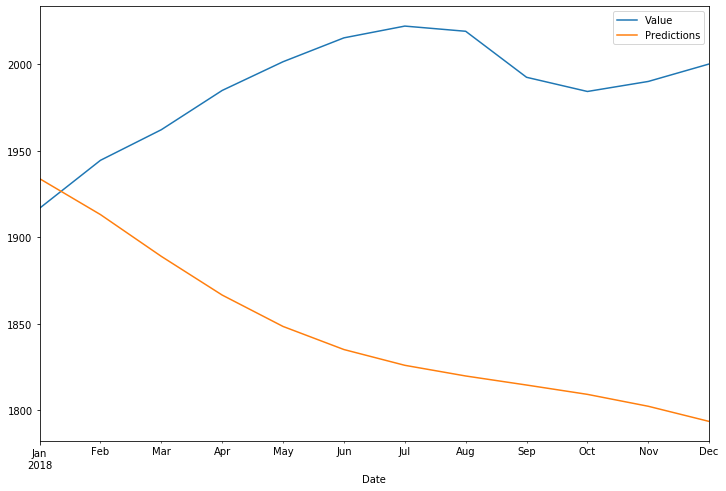

In [38]:
test.plot(figsize=(12,8))